# Problem Statement:
Despite advancements in Arabic POS tagging algorithms, achieving consistent accuracy remains a challenging task due to the language's complex morphology and dialectal variations. To address this challenge, employing graph analysis shows promise in capturing intricate word relationships. Challenges include constructing effective linguistic graphs, extracting relevant features, ensuring computational efficiency, and defining appropriate evaluation metrics tailored to Arabic's linguistic nuances. This approach aims to enhance the precision of POS tagging in diverse Arabic language contexts.

# Table of Contents

1. [**Step 1: Install and Import Required Libraries**](#step-1-install-and-import-required-libraries)
2. [**Step 2: Reading Data with Transforming to CSV**](#step-2-reading-data-with-transforming-to-csv)
3. [**Step 3: Data Cleaning and Pre-processing**](#step-3-data-cleaning-and-pre-processing)
   1. [**Step 3-1: Data Filtering**](#step-3-1-data-filtering)
   2. [**Step 3-2: Collate Sentences**](#step-3-2-collate-sentences)
   3. [**Step 3-3: Tokenization**](#step-3-3-tokenization)
   4. [**Step 3-4: Padding**](#step-3-4-padding)
4. [**Step 4: Word Embeddings From Aravec**](#step-4-word-embeddings-from-aravec)
5. [**Step 5: Finalizing the Shape of Data**](#step-5-finalizing-the-shape-of-data)
6. [**Step 6: Modeling**](#step-6-modeling)
   1. [**Step 6-1: Vanilla RNN**](#step-6-1-vanilla-rnn)
   2. [**Step 6-2: LSTM**](#step-6-2-lstm)
   3. [**Step 6-3: Bi-directional LSTM**](#step-6-3-bi-directional-lstm)
7. [**Step 7: Inference Using NetworkX**](#step-7-inference-using-networkx)

## Step 1 : Install and Import Required Libraries

In [ ]:
# Install the conllu package 
!pip install conllu

In [ ]:
# Install the tqdm package for displaying progress bars in the console
!pip install tqdm

In [ ]:
# Install the Keras library
!pip install keras

In [ ]:
# Install the TensorFlow library
!pip install tensorflow

In [ ]:
# Install the python-bidi package for bidirectional text handling
!pip install python-bidi

In [ ]:
# Install the arabic-reshaper package for reshaping Arabic text for proper display
!pip install arabic-reshaper

In [1]:
# import necessary libraries
import warnings
warnings.filterwarnings("ignore")

import numpy as np
import pandas as pd
import csv
import seaborn as sns
import networkx as nx
import gensim
import networkx as nx
import matplotlib.pyplot as plt
import arabic_reshaper
import seaborn as sns
import random

from tqdm import tqdm
from keras.preprocessing.text import Tokenizer
from keras.utils import to_categorical
from conllu import parse, parse_incr
from keras.preprocessing.sequence import pad_sequences
from matplotlib import pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.metrics import f1_score
from gensim.models import KeyedVectors
from keras.models import Sequential
from keras.layers import Embedding
from keras.layers import Dense, Input
from keras.layers import TimeDistributed
from keras.layers import LSTM, Bidirectional, SimpleRNN, RNN
from keras.models import Model
from keras.layers import Dropout
from bidi.algorithm import get_display
from sklearn.preprocessing import MultiLabelBinarizer

In [2]:
# Import classes from python scripts
from Data_Preparation import PreProcessing
from Word_Embeddings import EmbeddingProcessing

## Step 2 : Reading data with transforming to csv

In [3]:
# Create an instance of PreProcessing class
processor = PreProcessing()

In [4]:
# Specify the path to your CoNLL-U file
conllu_file_path = "C:/Users/Mustafa Abdulnasser/Desktop/Task1/data/ar_padt-ud-train.conllu"

# Specify the path to the output file
output_file_path = "C:/Users/Mustafa Abdulnasser/Desktop/Task1/data/train.csv"

# Call conllu_to_dataframe to generate the CSV file from CoNLL-U
train_df = processor.conllu_to_dataframe(conllu_file_path, output_file_path)

CSV file C:/Users/Mustafa Abdulnasser/Desktop/Task1/data/train.csv generated successfully.


In [5]:
# Print the DataFrame
train_df.head()

,ID,FORM,LEMMA,UPOS,XPOS,FEATS,HEAD,DEPREL,DEPS,MISC
0,1,برلين,بَرلِين,X,X---------,Foreign=Yes,2,nsubj,2:nsubj,Vform=بَرلِين|Gloss=Berlin|Root=barlIn|Transli...
1,2,ترفض,رَفَض,VERB,VIIA-3FS--,Aspect=Imp|Gender=Fem|Mood=Ind|Number=Sing|Per...,0,root,0:root,"Vform=تَرفُضُ|Gloss=reject,refuse|Root=r_f_.d|..."
2,3,حصول,حُصُول,NOUN,N------S4R,Case=Acc|Definite=Cons|Number=Sing,2,obj,2:obj,"Vform=حُصُولَ|Gloss=acquisition,obtaining,occu..."
3,4,شركة,شَرِكَة,NOUN,N------S2I,Case=Gen|Definite=Ind|Number=Sing,3,nmod,3:nmod:gen,"Vform=شَرِكَةٍ|Gloss=company,corporation|Root=..."
4,5,اميركية,أَمِيرِكِيّ,ADJ,A-----FS2I,Case=Gen|Definite=Ind|Gender=Fem|Number=Sing,4,amod,4:amod,Vform=أَمِيرِكِيَّةٍ|Gloss=American|Root='amIr...


In [6]:
# Specify the path to your CoNLL-U file
conllu_file_path = "C:/Users/Mustafa Abdulnasser/Desktop/Task1/data/ar_padt-ud-dev.conllu"

# Specify the path to the output file
output_file_path = "C:/Users/Mustafa Abdulnasser/Desktop/Task1/data/dev.csv"

# Call conllu_to_dataframe to generate the CSV file from CoNLL-U
val_df = processor.conllu_to_dataframe(conllu_file_path, output_file_path)

CSV file C:/Users/Mustafa Abdulnasser/Desktop/Task1/data/dev.csv generated successfully.


In [7]:
# Print the DataFrame
val_df.head()

,ID,FORM,LEMMA,UPOS,XPOS,FEATS,HEAD,DEPREL,DEPS,MISC
0,1,ميراث,مِيرَاث,NOUN,N------S1I,Case=Nom|Definite=Ind|Number=Sing,6,nsubj,6:nsubj,"Vform=مِيرَاثٌ|Gloss=inheritance,heritage|Root..."
1,2,ب,بِ,ADP,P---------,AdpType=Prep,3,case,3:case,"SpaceAfter=No|Vform=بِ|Gloss=by,with|Root=bi|T..."
2,3,300,300,NUM,Q---------,NumForm=Digit,1,nummod,1:nummod,Vform=٣٠٠|Translit=300
3,4,الف,أَلف,NUM,QM-----S2R,Case=Gen|Definite=Cons|Number=Sing|NumForm=Word,3,nummod,3:nummod,Vform=أَلفِ|Gloss=thousand|Root='_l_f|Translit...
4,5,دولار,دُولَار,NOUN,N------S2I,Case=Gen|Definite=Ind|Number=Sing,4,nmod,4:nmod:gen,Vform=دُولَارٍ|Gloss=dollar|Root=dUlAr|Transli...


In [8]:
# Specify the path to your CoNLL-U file
conllu_file_path = "C:/Users/Mustafa Abdulnasser/Desktop/Task1/data/ar_padt-ud-test.conllu"

# Specify the path to the output file
output_file_path = "C:/Users/Mustafa Abdulnasser/Desktop/Task1/data/test.csv"

# Call conllu_to_dataframe to generate the CSV file from CoNLL-U
test_df = processor.conllu_to_dataframe(conllu_file_path, output_file_path)

CSV file C:/Users/Mustafa Abdulnasser/Desktop/Task1/data/test.csv generated successfully.


In [9]:
# Print the DataFrame
test_df.head()

,ID,FORM,LEMMA,UPOS,XPOS,FEATS,HEAD,DEPREL,DEPS,MISC
0,1,سوريا,سُورِيَا,X,X---------,Foreign=Yes,0,root,0:root,SpaceAfter=No|Vform=سُورِيَا|Gloss=Syria|Root=...
1,2,:,:,PUNCT,G---------,_,1,punct,1:punct,Vform=:|Translit=:
2,3,تعديل,تَعدِيل,NOUN,N------S1I,Case=Nom|Definite=Ind|Number=Sing,6,nsubj,6:nsubj,"Vform=تَعدِيلٌ|Gloss=adjustment,change,modific..."
3,4,وزاري,وِزَارِيّ,ADJ,A-----MS1I,Case=Nom|Definite=Ind|Gender=Masc|Number=Sing,3,amod,3:amod,"Vform=وِزَارِيٌّ|Gloss=ministry,ministerial|Ro..."
4,5,واسع,وَاسِع,ADJ,A-----MS1I,Case=Nom|Definite=Ind|Gender=Masc|Number=Sing,3,amod,3:amod,"Vform=وَاسِعٌ|Gloss=wide,extensive,broad|Root=..."


## Step 3 : Data Cleaning and Pre-processing

### Step 3-1 : Data Filtering

In [10]:
# Call process_dataframe to perform additional processing and filtering on training dataframe
train_df_filtered = processor.process_dataframe(train_df)

In [11]:
# Print the filtered training dataframe
train_df_filtered

,ID,FORM,UPOS
0,1,برلين,X
1,2,ترفض,VERB
2,3,حصول,NOUN
3,4,شركة,NOUN
4,5,اميركية,ADJ
...,...,...,...
223795,16,الاسراع,X
223796,17,فى,ADP
223797,18,تنفيذ,NOUN
223798,19,ها,PRON


In [12]:
# Display the count of unique values in the 'UPOS' column of the filtered training DataFrame
train_df_filtered['UPOS'].value_counts()

NOUN     74519
ADP      33606
ADJ      23485
PUNCT    17506
VERB     16786
CCONJ    15799
X        13740
PRON      8531
NUM       6010
DET       4648
SCONJ     4366
PART      1709
AUX       1699
ADV        880
SYM        329
PROPN      187
Name: UPOS, dtype: int64

In [13]:
# Call process_dataframe to perform additional processing and filtering on validation dataframe
val_df_filtered = processor.process_dataframe(val_df)

In [14]:
# Print the filtered validation dataframe
val_df_filtered

,ID,FORM,UPOS
0,1,ميراث,NOUN
1,2,ب,ADP
2,3,300,NUM
3,4,الف,NUM
4,5,دولار,NOUN
...,...,...,...
30170,3,متى,DET
30171,4,س,AUX
30172,5,يتم,VERB
30173,6,تسليم,NOUN


In [15]:
# Display the count of unique values in the 'UPOS' column of the filtered validation DataFrame
val_df_filtered['UPOS'].value_counts()

NOUN     9597
ADP      4401
ADJ      2911
PUNCT    2874
VERB     2314
X        2036
CCONJ    2012
PRON     1206
NUM       967
DET       624
SCONJ     555
PART      270
AUX       257
ADV       108
PROPN      25
SYM        18
Name: UPOS, dtype: int64

In [16]:
# Call process_dataframe to perform additional processing and filtering on testing dataframe
test_df_filtered = processor.process_dataframe(test_df)

In [17]:
# Display the count of unique values in the 'UPOS' column of the filtered testing DataFrame
test_df_filtered['UPOS'].value_counts()

NOUN     9522
ADP      4514
ADJ      2931
VERB     2184
PUNCT    2047
CCONJ    1958
X        1368
PRON     1131
NUM       778
DET       622
SCONJ     534
PART      226
AUX       196
ADV       104
SYM        41
PROPN      31
Name: UPOS, dtype: int64

### Step 3-2 : Collate sentences 

In [18]:
# Call collate_samples to generate batches from train_df_filtered
train_text, train_tags = processor.collate_samples(train_df_filtered)

In [19]:
# let's look at first data point
# this is one data point that will be fed to the RNN
print('sample X: ', train_text[0], '\n')
print('sample Y: ', train_tags[0][::-1], '\n')

sample X:  ['برلين', 'ترفض', 'حصول', 'شركة', 'اميركية', 'على', 'رخصة', 'تصنيع', 'دبابة', '"', 'ليوبارد', '"', 'الالمانية'] 

sample Y:  ['ADJ', 'PUNCT', 'X', 'PUNCT', 'NOUN', 'NOUN', 'NOUN', 'ADP', 'ADJ', 'NOUN', 'NOUN', 'VERB', 'X'] 



In [20]:
# In this many-to-many problem, the length of each input and output sequence must be the same.
# Since each word is tagged, it's important to make sure that the length of input sequence equals the output sequence
print("Length of first input sequence  : {}".format(len(train_text[0])))
print("Length of first output sequence : {}".format(len(train_tags[0])))

Length of first input sequence  : 13
Length of first output sequence : 13


In [21]:
# Call collate_samples to generate batches from val_df_filtered
val_text, val_tags = processor.collate_samples(val_df_filtered)

In [22]:
# Call collate_samples to generate batches from test_df_filtered
test_text, test_tags = processor.collate_samples(test_df_filtered)

In [23]:
# For train set
print("** Train set **", "\n", "-"*100, "\n")
print(f"Text length = {len(train_text)}, Tags length = {len(train_tags)}", "\n")

# For validation set
print("** Validation set **", "\n", "-"*100, "\n")
print(f"Text length = {len(val_text)}, Tags length = {len(val_tags)}", "\n")

# For test set
print("** Test set **", "\n", "-"*100, "\n")
print(f"Text length = {len(test_text)}, Tags length = {len(test_tags)}", "\n")

** Train set ** 
 ---------------------------------------------------------------------------------------------------- 

Text length = 6073, Tags length = 6073 

** Validation set ** 
 ---------------------------------------------------------------------------------------------------- 

Text length = 906, Tags length = 906 

** Test set ** 
 ---------------------------------------------------------------------------------------------------- 

Text length = 678, Tags length = 678 



### Step 3-3 : Tokenization 

In [24]:
# Step 1: Define the out-of-vocabulary token
oov_tok = "<OOV>"

# Step 2: Fit tokenizer on training set
word_tokenizer = Tokenizer(oov_token = oov_tok)
word_tokenizer.fit_on_texts(train_text)

# Step 3: Apply fitted tokenizer to train, validation and test sets
train_text_encodded = word_tokenizer.texts_to_sequences(train_text)
val_text_encodded = word_tokenizer.texts_to_sequences(val_text)
test_text_encodded = word_tokenizer.texts_to_sequences(test_text)

In [25]:
# Step 1: Fit tokenizer on training set
tag_tokenizer = Tokenizer()
tag_tokenizer.fit_on_texts(train_tags)

# Step 3: Apply fitted tokenizer to train, validation and test sets
train_tags_encodded = tag_tokenizer.texts_to_sequences(train_tags)
val_tags_encodded   = tag_tokenizer.texts_to_sequences(val_tags)
test_tags_encodded  = tag_tokenizer.texts_to_sequences(test_tags)

In [26]:
# look at first encoded data point

print("** Raw data point **", "\n", "-"*100, "\n")
print('X: ', train_text[0], '\n')
print('Y: ', train_tags[0][::-1], '\n')
print()
print("** Encoded data point **", "\n", "-"*100, "\n")
print('X: ', train_text_encodded[0], '\n')
print('Y: ', train_tags_encodded[0], '\n')

** Raw data point ** 
 ---------------------------------------------------------------------------------------------------- 

X:  ['برلين', 'ترفض', 'حصول', 'شركة', 'اميركية', 'على', 'رخصة', 'تصنيع', 'دبابة', '"', 'ليوبارد', '"', 'الالمانية'] 

Y:  ['ADJ', 'PUNCT', 'X', 'PUNCT', 'NOUN', 'NOUN', 'NOUN', 'ADP', 'ADJ', 'NOUN', 'NOUN', 'VERB', 'X'] 


** Encoded data point ** 
 ---------------------------------------------------------------------------------------------------- 

X:  [3268, 2174, 948, 87, 2035, 12, 3269, 1681, 3641, 10, 4109, 10, 1576] 

Y:  [7, 5, 1, 1, 3, 2, 1, 1, 1, 4, 7, 4, 3] 



In [27]:
# make sure that each sequence of input and output is same length

different_length = [1 if len(input) != len(output) else 0 for input, output in zip(train_text_encodded, train_tags_encodded)]
print("{} sentences have disparate input-output lengths.".format(sum(different_length)))

0 sentences have disparate input-output lengths.


### Step 3-4 : Padding

In [28]:
# check length of longest sentence
lengths = [len(seq) for seq in train_text_encodded]
print("Length of longest sentence: {}".format(max(lengths)))

Length of longest sentence: 398


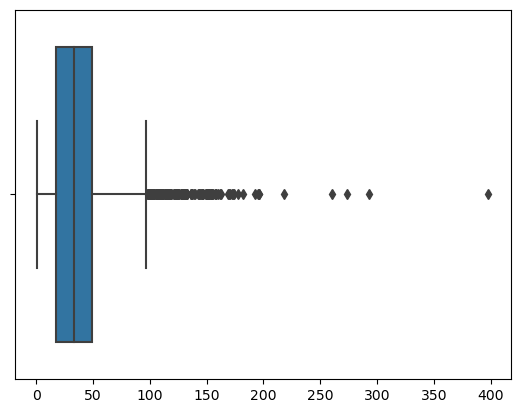

In [29]:
# Create a boxplot to visualize the distribution of 'lengths' using Seaborn
sns.boxplot(lengths)
plt.show()

In [30]:
# Sentences longer than MAX_SEQ_LENGTH are truncated.
# Sentences shorter than MAX_SEQ_LENGTH are padded with zeroes.

# Truncation and padding can either be 'pre' or 'post'. 
# For padding we are using 'post' padding type, that is, add zeroes on the right side.
# For truncation, we are using 'post', that is, truncate a sentence from right side.

MAX_SEQ_LENGTH = 100  # sequences greater than 100 in length will be truncated
PADDING = "post"
TRUNCATING = "post"

In [31]:
# Pad sequences for training text and tags
train_text_padded = pad_sequences(train_text_encodded, maxlen = MAX_SEQ_LENGTH, padding = PADDING, truncating = TRUNCATING)
train_tags_padded = pad_sequences(train_tags_encodded, maxlen = MAX_SEQ_LENGTH, padding = PADDING, truncating = TRUNCATING)

In [32]:
# print the first sequence
print(train_text_padded[0], "\n"*2)
print(train_tags_padded[0])

[3268 2174  948   87 2035   12 3269 1681 3641   10 4109   10 1576    0
    0    0    0    0    0    0    0    0    0    0    0    0    0    0
    0    0    0    0    0    0    0    0    0    0    0    0    0    0
    0    0    0    0    0    0    0    0    0    0    0    0    0    0
    0    0    0    0    0    0    0    0    0    0    0    0    0    0
    0    0    0    0    0    0    0    0    0    0    0    0    0    0
    0    0    0    0    0    0    0    0    0    0    0    0    0    0
    0    0] 


[7 5 1 1 3 2 1 1 1 4 7 4 3 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]


In [33]:
# Pad sequences for validation text and tags
val_text_padded = pad_sequences(val_text_encodded, maxlen = MAX_SEQ_LENGTH, padding = PADDING, truncating = TRUNCATING)
val_tags_padded = pad_sequences(val_tags_encodded, maxlen = MAX_SEQ_LENGTH, padding = PADDING, truncating = TRUNCATING)

In [34]:
# Pad sequences for testing text and tags
test_text_padded = pad_sequences(test_text_encodded, maxlen = MAX_SEQ_LENGTH, padding = PADDING, truncating = TRUNCATING)
test_tags_padded = pad_sequences(test_tags_encodded, maxlen = MAX_SEQ_LENGTH, padding = PADDING, truncating = TRUNCATING)

## Step 4 : Word embeddings From Aravec

Word embeddings are a type of word representation that allows words with similar meaning to have a similar representation. So we used an embedding matrix from Aravec, short for "Arabic Word Embeddings," refers to pre-trained word embeddings specifically designed for the Arabic language. Word embeddings are dense vector representations of words in a continuous vector space, capturing semantic relationships between words. Aravec models are trained on large Arabic text corpora.

In [35]:
# Create an instance of EmbeddingProcessing for handling word embeddings
embedding_processor = EmbeddingProcessing()

In [36]:
# Load the Aravec model
embedding_processor.load_embedding_model('C:/Users/Mustafa Abdulnasser/Desktop/Task1/pre-trained models/Aravec/full_grams_cbow_300_twitter.mdl')

In [37]:
# Create embeddings and get the weights matrix
embeddings_weights_matrix = embedding_processor.create_embeddings(word_tokenizer)

In [38]:
# check embedding dimension
print("Embeddings shape: {}".format(embeddings_weights_matrix.shape))

Embeddings shape: (21912, 300)


In [39]:
# let's look at an embedding of a word
embeddings_weights_matrix[word_tokenizer.word_index["تصنيع"]]

array([-0.44167799, -0.12264249, -0.83759761,  0.74162811,  0.14888309,
        1.6253283 , -0.08094976,  0.9875744 ,  2.09851813, -0.57073832,
        0.25962695, -0.18513481,  1.66615903, -1.89694452,  1.73901367,
       -2.13350272, -1.36926341,  0.12772602,  0.03725654,  2.28725553,
       -0.42084751,  1.07584512, -0.03384755,  2.1100378 , -0.50779694,
       -0.09196451,  0.51976299, -0.87050188, -1.57642865, -0.83160627,
        0.39785618,  1.29374361,  0.51660836, -1.27360678, -2.78768468,
        0.70043164,  0.67396247, -1.10744011,  0.33184752,  0.64798385,
       -0.26200843, -0.86442125, -1.02560961, -0.2807537 , -0.89266711,
       -0.04493473,  0.65678018, -1.05219662, -0.43776372, -0.22610559,
        0.51528615,  2.85615706, -0.53063774, -0.16158924,  1.39316475,
       -1.392156  , -0.89056009, -0.57549548, -0.38506714, -0.78499866,
        0.67320281, -0.70221192, -0.34168112, -0.852741  ,  0.22764838,
        1.85714209, -0.85544926,  0.64074004, -0.39517245,  0.32

## Step 5 : Finalizing the Shape of Data

In [40]:
# assign padded sequences to X_train and Y_train
X_train, Y_train = train_text_padded, train_tags_padded

In [41]:
# assign padded sequences to X_val and Y_val
X_val, Y_val = val_text_padded, val_tags_padded

In [42]:
# assign padded sequences to X_test and Y_test
X_test, Y_test = test_text_padded, test_tags_padded

In [43]:
# use Keras' to_categorical function to one-hot encode Y
Y_train = to_categorical(Y_train)
Y_val   = to_categorical(Y_val)
Y_test  = to_categorical(Y_test)

In [44]:
# print number of samples in each set
print("TRAINING DATA")
print('Shape of input sequences: {}'.format(X_train.shape))
print('Shape of output sequences: {}'.format(Y_train.shape))
print("-"*50)
print("VALIDATION DATA")
print('Shape of input sequences: {}'.format(X_val.shape))
print('Shape of output sequences: {}'.format(Y_val.shape))
print("-"*50)
print("TESTING DATA")
print('Shape of input sequences: {}'.format(X_test.shape))
print('Shape of output sequences: {}'.format(Y_test.shape))

TRAINING DATA
Shape of input sequences: (6073, 100)
Shape of output sequences: (6073, 100, 17)
--------------------------------------------------
VALIDATION DATA
Shape of input sequences: (906, 100)
Shape of output sequences: (906, 100, 17)
--------------------------------------------------
TESTING DATA
Shape of input sequences: (678, 100)
Shape of output sequences: (678, 100, 17)


## Step 6 :Modeling

Before using RNN, we must make sure the dimensions of the data are what an RNN expects. In general, an RNN expects the following shape

Shape of X_train: (#samples, #timesteps, #features)

Shape of Y_train: (#samples, #timesteps, #features)

RNN tensor shape

Now, there can be various variations in the shape that you use to feed an RNN depending on the type of architecture. Since the problem we're working on has a many-to-many architecture, the input and the output both include number of timesteps which is nothing but the sequence length. But notice that the tensor X doesn't have the third dimension, that is, number of features. That's because we're going to use word embeddings before feeding in the data to an RNN, and hence there is no need to explicitly mention the third dimension. That's because when you use the Embedding() layer in Keras, you the training data will automatically be converted to (#samples, #timesteps, #features) where #features will be the embedding dimention (and note that the Embedding layer is always the very first layer of an RNN). While using the embedding layer we only need to reshape the data to (#samples, #timesteps) which is what we have done. However, note that you'll need to shape it to (#samples, #timesteps, #features) in case you don't use the Embedding() layer in Keras.

### Step 6-1 : Vanilla RNN

Uninitialised fixed embeddings
First let's try running a vanilla RNN. For this RNN we won't use the pre-trained word embeddings. We'll use randomly inititalised embeddings. Moreover, we won't update the embeddings weights

In [45]:
# Calculate the vocabulary size by adding 1 to the length of the word tokenizer's word index
VOCABULARY_SIZE = len(word_tokenizer.word_index) + 1

In [46]:
# Set the dimensionality of word embeddings to 300
EMBEDDING_DIM = 300

In [47]:
# total number of tags
NUM_CLASSES = Y_train.shape[2]

In [48]:
# create architecture

rnn_model = Sequential()

# create embedding layer - usually the first layer in text problems
rnn_model.add(Embedding(input_dim     =  VOCABULARY_SIZE,         # vocabulary size - number of unique words in data
                        output_dim    =  EMBEDDING_DIM,          # length of vector with which each word is represented
                        input_length  =  MAX_SEQ_LENGTH,          # length of input sequence
                        trainable     =  False                    # False - don't update the embeddings
))

# add an RNN layer which contains 64 RNN cells
rnn_model.add(SimpleRNN(64, 
              return_sequences=True  # True - return whole sequence; False - return single output of the end of the sequence
))

# add time distributed (output at each sequence) layer
rnn_model.add(TimeDistributed(Dense(NUM_CLASSES, activation='softmax')))

In [49]:
# Compile the RNN model with categorical crossentropy loss, Adam optimizer, and accuracy metric
rnn_model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['acc'])

In [50]:
# check summary of the model
rnn_model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding (Embedding)       (None, 100, 300)          6573600   
                                                                 
 simple_rnn (SimpleRNN)      (None, 100, 64)           23360     
                                                                 
 time_distributed (TimeDist  (None, 100, 17)           1105      
 ributed)                                                        
                                                                 
Total params: 6598065 (25.17 MB)
Trainable params: 24465 (95.57 KB)
Non-trainable params: 6573600 (25.08 MB)
_________________________________________________________________


In [51]:
# Train the RNN model on the training data for 10 epochs with a batch size of 128,
# validating on the provided validation set
rnn_training = rnn_model.fit(X_train, Y_train, batch_size=128, epochs=10, validation_data=(X_val, Y_val))

Epoch 1/10


48/48 [==============================] - 3s 45ms/step - loss: 1.2464 - acc: 0.6857 - val_loss: 0.8031 - val_acc: 0.7621
Epoch 2/10
48/48 [==============================] - 2s 35ms/step - loss: 0.8159 - acc: 0.7564 - val_loss: 0.7432 - val_acc: 0.7719
Epoch 3/10
48/48 [==============================] - 2s 36ms/step - loss: 0.7681 - acc: 0.7637 - val_loss: 0.7014 - val_acc: 0.7824
Epoch 4/10
48/48 [==============================] - 2s 37ms/step - loss: 0.7198 - acc: 0.7767 - val_loss: 0.6534 - val_acc: 0.8061
Epoch 5/10
48/48 [==============================] - 2s 37ms/step - loss: 0.6653 - acc: 0.8134 - val_loss: 0.6024 - val_acc: 0.8355
Epoch 6/10
48/48 [==============================] - 2s 34ms/step - loss: 0.6120 - acc: 0.8359 - val_loss: 0.5573 - val_acc: 0.8469
Epoch 7/10
48/48 [==============================] - 2s 36ms/step - loss: 0.5663 - acc: 0.8450 - val_loss: 0.5186 - val_acc: 0.8557
Epoch 8/10
48/48 [==============================] - 2s 35ms/step - loss: 0.5282 -

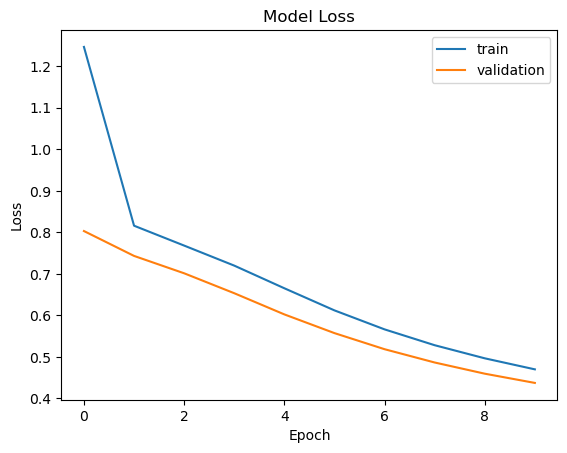

In [56]:
# visualise training history
plt.plot(rnn_training.history['loss'])  # Use 'loss' instead of 'acc' for training loss
plt.plot(rnn_training.history['val_loss'])  # Use 'val_loss' instead of 'val_acc' for validation loss
plt.title('Model Loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['train', 'validation'], loc="upper right")
plt.show()

In [53]:
# Predicting using the RNN model on the test data
y_pred = rnn_model.predict(X_test)

22/22 [==============================] - 0s 8ms/step


In [54]:
def one_hot_encode_3d(data):
    """
    Apply one-hot encoding to a 3D numpy array. 
    The one-hot encoding will be applied along the last axis of the array.
    """
    # Initialize an array of zeros with the same shape as the input data
    one_hot_encoded = np.zeros_like(data)

    # Iterate over the first and second dimensions and apply one-hot encoding
    for i in range(data.shape[0]):
        for j in range(data.shape[1]):
            index_of_max_value = np.argmax(data[i, j, :])
            one_hot_encoded[i, j, index_of_max_value] = 1

    return one_hot_encoded

In [59]:
# Evaluate the RNN model on the test set
loss, accuracy = rnn_model.evaluate(X_test, Y_test, verbose=0)

# Apply one-hot encoding to predictions
one_hot_encoded_data_3d = one_hot_encode_3d(y_pred)

# Flattening the arrays to 2D for multi-label classification
y_true_flat = Y_test.reshape(-1, Y_test.shape[-1])
y_pred_flat = one_hot_encoded_data_3d.reshape(-1, one_hot_encoded_data_3d.shape[-1])

# Calculate the F1 score
result_1 = f1_score(y_true_flat, y_pred_flat, average="weighted")

# Print the weighted F1-Score
print(f"Weighted F1-Score: {round(result_1 * 100, 2)} %")

# Print accuracy in a similar format
print(f"Accuracy: {round(accuracy * 100, 2)} %")

Weighted F1-Score: 82.36 %
Accuracy: 85.16 %


#### Uninitialised trainable embeddings

In [61]:
# create architecture

rnn_model = Sequential()

# create embedding layer - usually the first layer in text problems
rnn_model.add(Embedding(input_dim     =  VOCABULARY_SIZE,         # vocabulary size - number of unique words in data
                        output_dim    =  EMBEDDING_DIM,          # length of vector with which each word is represented
                        input_length  =  MAX_SEQ_LENGTH,          # length of input sequence
                        trainable     =  True                     # True - update the embeddings while training
))

# add an RNN layer which contains 64 RNN cells
rnn_model.add(SimpleRNN(64, 
              return_sequences=True  # True - return whole sequence; False - return single output of the end of the sequence
))

# add time distributed (output at each sequence) layer
rnn_model.add(TimeDistributed(Dense(NUM_CLASSES, activation='softmax')))

In [62]:
# Compile the RNN model with categorical crossentropy loss, Adam optimizer, and accuracy metric
rnn_model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['acc'])

In [63]:
# check summary of the model
rnn_model.summary()

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding_1 (Embedding)     (None, 100, 300)          6573600   
                                                                 
 simple_rnn_1 (SimpleRNN)    (None, 100, 64)           23360     
                                                                 
 time_distributed_1 (TimeDi  (None, 100, 17)           1105      
 stributed)                                                      
                                                                 
Total params: 6598065 (25.17 MB)
Trainable params: 6598065 (25.17 MB)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________


In [64]:
# Train the RNN model on the training data for 10 epochs with a batch size of 128,
# validating on the provided validation set
rnn_training = rnn_model.fit(X_train, Y_train, batch_size=128, epochs=10, validation_data=(X_val, Y_val))

Epoch 1/10
48/48 [==============================] - 7s 130ms/step - loss: 1.1928 - acc: 0.6879 - val_loss: 0.6900 - val_acc: 0.7927
Epoch 2/10
48/48 [==============================] - 6s 126ms/step - loss: 0.5923 - acc: 0.8488 - val_loss: 0.4279 - val_acc: 0.9072
Epoch 3/10
48/48 [==============================] - 6s 127ms/step - loss: 0.3259 - acc: 0.9331 - val_loss: 0.2422 - val_acc: 0.9467
Epoch 4/10
48/48 [==============================] - 6s 126ms/step - loss: 0.1765 - acc: 0.9674 - val_loss: 0.1554 - val_acc: 0.9662
Epoch 5/10
48/48 [==============================] - 6s 126ms/step - loss: 0.1043 - acc: 0.9828 - val_loss: 0.1143 - val_acc: 0.9730
Epoch 6/10
48/48 [==============================] - 6s 126ms/step - loss: 0.0677 - acc: 0.9891 - val_loss: 0.0947 - val_acc: 0.9756
Epoch 7/10
48/48 [==============================] - 6s 126ms/step - loss: 0.0484 - acc: 0.9918 - val_loss: 0.0852 - val_acc: 0.9772
Epoch 8/10
48/48 [==============================] - 6s 128ms/step - loss: 0.

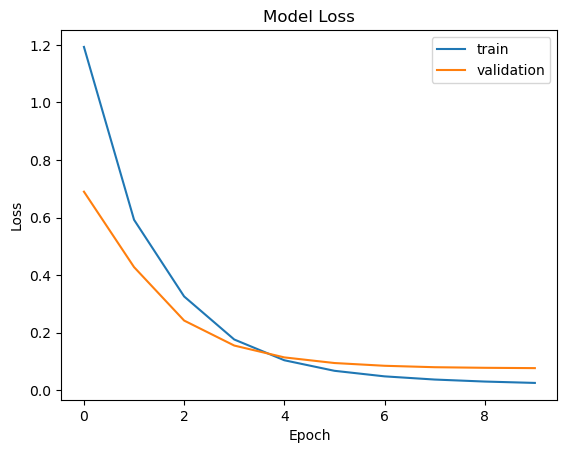

In [65]:
# visualise training history
plt.plot(rnn_training.history['loss'])  # Use 'loss' instead of 'acc' for training loss
plt.plot(rnn_training.history['val_loss'])  # Use 'val_loss' instead of 'val_acc' for validation loss
plt.title('Model Loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['train', 'validation'], loc="upper right")
plt.show()

In [67]:
# Predicting using the RNN model on the test data
y_pred = rnn_model.predict(X_test)

22/22 [==============================] - 0s 8ms/step


In [68]:
# Evaluate the RNN model on the test set
loss, accuracy = rnn_model.evaluate(X_test, Y_test, verbose=0)

# Apply one-hot encoding to predictions
one_hot_encoded_data_3d = one_hot_encode_3d(y_pred)

# Flattening the arrays to 2D for multi-label classification
y_true_flat = Y_test.reshape(-1, Y_test.shape[-1])
y_pred_flat = one_hot_encoded_data_3d.reshape(-1, one_hot_encoded_data_3d.shape[-1])

# Calculate the F1 score
result_1 = f1_score(y_true_flat, y_pred_flat, average="weighted")

# Print the weighted F1-Score
print(f"Weighted F1-Score: {round(result_1 * 100, 2)} %")

# Print accuracy in a similar format
print(f"Accuracy: {round(accuracy * 100, 2)} %")

Weighted F1-Score: 97.41 %
Accuracy: 97.5 %


#### Using pre-trained embedding weights

In [69]:
# create architecture

rnn_model = Sequential()

# create embedding layer - usually the first layer in text problems
rnn_model.add(Embedding(input_dim     =  VOCABULARY_SIZE,         # vocabulary size - number of unique words in data
                        output_dim    =  EMBEDDING_DIM,          # length of vector with which each word is represented
                        input_length  =  MAX_SEQ_LENGTH,          # length of input sequence
                        weights       = [embeddings_weights_matrix],      # word embedding matrix
                        trainable     =  True                     # True - update the embeddings while training
))

# add an RNN layer which contains 64 RNN cells
rnn_model.add(SimpleRNN(64, 
              return_sequences=True,   # True - return whole sequence; False - return single output of the end of the sequence
))

# add time distributed (output at each sequence) layer
rnn_model.add(TimeDistributed(Dense(NUM_CLASSES, activation='softmax')))

In [70]:
# Compile the RNN model with categorical crossentropy loss, Adam optimizer, and accuracy metric
rnn_model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['acc'])

In [71]:
# check summary of the model
rnn_model.summary()

Model: "sequential_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding_2 (Embedding)     (None, 100, 300)          6573600   
                                                                 
 simple_rnn_2 (SimpleRNN)    (None, 100, 64)           23360     
                                                                 
 time_distributed_2 (TimeDi  (None, 100, 17)           1105      
 stributed)                                                      
                                                                 
Total params: 6598065 (25.17 MB)
Trainable params: 6598065 (25.17 MB)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________


In [72]:
# Train the RNN model on the training data for 10 epochs with a batch size of 128,
# validating on the provided validation set
rnn_training = rnn_model.fit(X_train, Y_train, batch_size=128, epochs=10, validation_data=(X_val, Y_val))

Epoch 1/10
48/48 [==============================] - 8s 143ms/step - loss: 0.8599 - acc: 0.8053 - val_loss: 0.3899 - val_acc: 0.8983
Epoch 2/10
48/48 [==============================] - 7s 144ms/step - loss: 0.3095 - acc: 0.9231 - val_loss: 0.2523 - val_acc: 0.9380
Epoch 3/10
48/48 [==============================] - 6s 128ms/step - loss: 0.1999 - acc: 0.9537 - val_loss: 0.1803 - val_acc: 0.9563
Epoch 4/10
48/48 [==============================] - 6s 124ms/step - loss: 0.1367 - acc: 0.9687 - val_loss: 0.1341 - val_acc: 0.9653
Epoch 5/10
48/48 [==============================] - 6s 124ms/step - loss: 0.1016 - acc: 0.9769 - val_loss: 0.1122 - val_acc: 0.9698
Epoch 6/10
48/48 [==============================] - 7s 141ms/step - loss: 0.0798 - acc: 0.9818 - val_loss: 0.0993 - val_acc: 0.9719
Epoch 7/10
48/48 [==============================] - 7s 138ms/step - loss: 0.0655 - acc: 0.9848 - val_loss: 0.0908 - val_acc: 0.9737
Epoch 8/10
48/48 [==============================] - 6s 126ms/step - loss: 0.

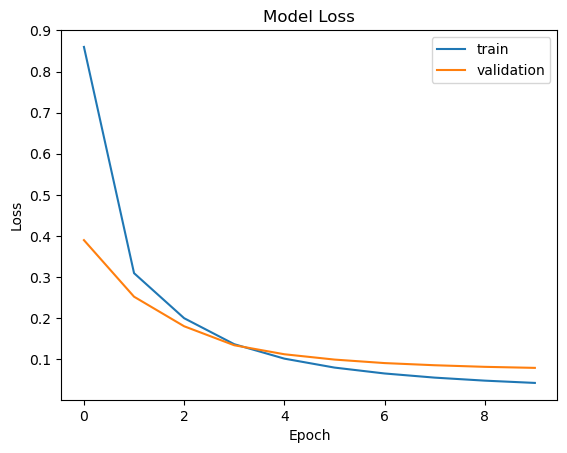

In [73]:
# visualise training history
plt.plot(rnn_training.history['loss'])  # Use 'loss' instead of 'acc' for training loss
plt.plot(rnn_training.history['val_loss'])  # Use 'val_loss' instead of 'val_acc' for validation loss
plt.title('Model Loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['train', 'validation'], loc="upper right")
plt.show()

In [74]:
# Predicting using the RNN model on the test data
y_pred = rnn_model.predict(X_test)

22/22 [==============================] - 0s 8ms/step


In [78]:
# Evaluate the RNN model on the test set
loss, accuracy = rnn_model.evaluate(X_test, Y_test, verbose=0)

# Apply one-hot encoding to predictions
one_hot_encoded_data_3d = one_hot_encode_3d(y_pred)

# Flattening the arrays to 2D for multi-label classification
y_true_flat = Y_test.reshape(-1, Y_test.shape[-1])
y_pred_flat = one_hot_encoded_data_3d.reshape(-1, one_hot_encoded_data_3d.shape[-1])

# Calculate the F1 score
result_1 = f1_score(y_true_flat, y_pred_flat, average="weighted")

# Print the weighted F1-Score
print(f"Weighted F1-Score: {round(result_1 * 100, 2)} %")

# Print accuracy in a similar format
print(f"Accuracy: {round(accuracy * 100, 2)} %")

Weighted F1-Score: 97.19 %
Accuracy: 97.26 %


### Step 6-2 : LSTM
I'll use pre-trained word embeddings in following models and allow them to be updated as well.

In [79]:
# create architecture

lstm_model = Sequential()
lstm_model.add(Embedding(input_dim     = VOCABULARY_SIZE,         # vocabulary size - number of unique words in data
                         output_dim    = EMBEDDING_DIM,          # length of vector with which each word is represented
                         input_length  = MAX_SEQ_LENGTH,          # length of input sequence
                         weights       = [embeddings_weights_matrix],     # word embedding matrix
                         trainable     = True                     # True - update embeddings_weight matrix
))

# add an LSTM layer which contains 64 RNN cells
lstm_model.add(LSTM(64, return_sequences=True)) # True - return whole sequence; False - return single output of the end of the sequence

# add time distributed (output at each sequence) layer
lstm_model.add(TimeDistributed(Dense(NUM_CLASSES, activation='softmax')))

In [80]:
# Compile the LSTM model with categorical crossentropy loss, Adam optimizer, and accuracy metric
lstm_model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['acc'])

In [81]:
# check summary of the model
lstm_model.summary()

Model: "sequential_3"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding_3 (Embedding)     (None, 100, 300)          6573600   
                                                                 
 lstm (LSTM)                 (None, 100, 64)           93440     
                                                                 
 time_distributed_3 (TimeDi  (None, 100, 17)           1105      
 stributed)                                                      
                                                                 
Total params: 6668145 (25.44 MB)
Trainable params: 6668145 (25.44 MB)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________


In [82]:
# Train the LSTM model on the training data for 10 epochs with a batch size of 128,
# validating on the provided validation set
lstm_training = lstm_model.fit(X_train, Y_train, batch_size=128, epochs=10, validation_data=(X_val, Y_val))

Epoch 1/10
48/48 [==============================] - 11s 194ms/step - loss: 1.1335 - acc: 0.8072 - val_loss: 0.4166 - val_acc: 0.8850
Epoch 2/10
48/48 [==============================] - 9s 192ms/step - loss: 0.3587 - acc: 0.9012 - val_loss: 0.2814 - val_acc: 0.9289
Epoch 3/10
48/48 [==============================] - 9s 198ms/step - loss: 0.2411 - acc: 0.9431 - val_loss: 0.1952 - val_acc: 0.9505
Epoch 4/10
48/48 [==============================] - 9s 184ms/step - loss: 0.1596 - acc: 0.9630 - val_loss: 0.1408 - val_acc: 0.9657
Epoch 5/10
48/48 [==============================] - 9s 196ms/step - loss: 0.1110 - acc: 0.9765 - val_loss: 0.1123 - val_acc: 0.9707
Epoch 6/10
48/48 [==============================] - 9s 182ms/step - loss: 0.0842 - acc: 0.9818 - val_loss: 0.0969 - val_acc: 0.9732
Epoch 7/10
48/48 [==============================] - 9s 192ms/step - loss: 0.0681 - acc: 0.9851 - val_loss: 0.0879 - val_acc: 0.9740
Epoch 8/10
48/48 [==============================] - 9s 187ms/step - loss: 0

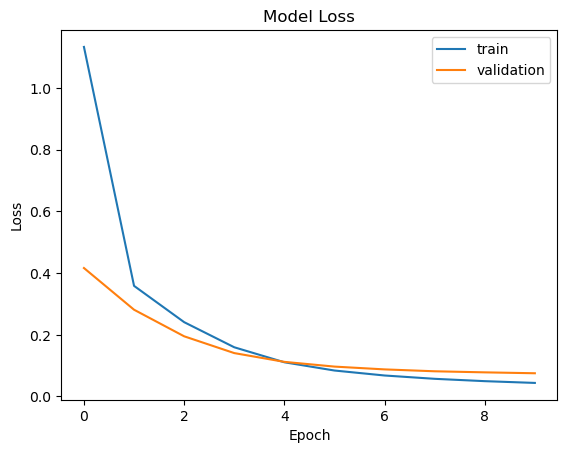

In [83]:
# visualise training history
plt.plot(lstm_training.history['loss'])  # Use 'loss' instead of 'acc' for training loss
plt.plot(lstm_training.history['val_loss'])  # Use 'val_loss' instead of 'val_acc' for validation loss
plt.title('Model Loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['train', 'validation'], loc="upper right")
plt.show()

In [85]:
# Predicting using the LSTM model on the test data
y_pred = lstm_model.predict(X_test)

22/22 [==============================] - 1s 17ms/step


In [86]:
# Evaluate the RNN model on the test set
loss, accuracy = lstm_model.evaluate(X_test, Y_test, verbose=0)

# Apply one-hot encoding to predictions
one_hot_encoded_data_3d = one_hot_encode_3d(y_pred)

# Flattening the arrays to 2D for multi-label classification
y_true_flat = Y_test.reshape(-1, Y_test.shape[-1])
y_pred_flat = one_hot_encoded_data_3d.reshape(-1, one_hot_encoded_data_3d.shape[-1])

# Calculate the F1 score
result_1 = f1_score(y_true_flat, y_pred_flat, average="weighted")

# Print the weighted F1-Score
print(f"Weighted F1-Score: {round(result_1 * 100, 2)} %")

# Print accuracy in a similar format
print(f"Accuracy: {round(accuracy * 100, 2)} %")

Weighted F1-Score: 97.3 %
Accuracy: 97.38 %


### Step 6-3 : Bi-directional LSTM

In [87]:
# create architecture

bidirect_model = Sequential()
bidirect_model.add(Embedding(input_dim     = VOCABULARY_SIZE,         # vocabulary size - number of unique words in data
                         output_dim    = EMBEDDING_DIM,          # length of vector with which each word is represented
                         input_length  = MAX_SEQ_LENGTH,          # length of input sequence
                         weights       = [embeddings_weights_matrix],     # word embedding matrix
                         trainable     = True                     # True - update embeddings_weight matrix
))

# add an BI-LSTM layer which contains 64 RNN cells
bidirect_model.add(Bidirectional(LSTM(64, return_sequences=True))) # True - return whole sequence; False - return single output of the end of the sequence

# add time distributed (output at each sequence) layer
bidirect_model.add(TimeDistributed(Dense(NUM_CLASSES, activation='softmax')))

In [88]:
# Compile the BI-LSTM model with categorical crossentropy loss, Adam optimizer, and accuracy metric
bidirect_model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['acc'])

In [89]:
# check summary of the model
bidirect_model.summary()

Model: "sequential_4"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding_4 (Embedding)     (None, 100, 300)          6573600   
                                                                 
 bidirectional (Bidirection  (None, 100, 128)          186880    
 al)                                                             
                                                                 
 time_distributed_4 (TimeDi  (None, 100, 17)           2193      
 stributed)                                                      
                                                                 
Total params: 6762673 (25.80 MB)
Trainable params: 6762673 (25.80 MB)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________


In [90]:
# Train the BI-LSTM model on the training data for 10 epochs with a batch size of 128,
# validating on the provided validation set
bilstm_training = bidirect_model.fit(X_train, Y_train, batch_size=128, epochs=10, validation_data=(X_val, Y_val))

Epoch 1/10
48/48 [==============================] - 17s 294ms/step - loss: 0.9940 - acc: 0.8225 - val_loss: 0.3361 - val_acc: 0.9005
Epoch 2/10
48/48 [==============================] - 13s 277ms/step - loss: 0.2845 - acc: 0.9195 - val_loss: 0.2171 - val_acc: 0.9433
Epoch 3/10
48/48 [==============================] - 14s 286ms/step - loss: 0.1739 - acc: 0.9577 - val_loss: 0.1379 - val_acc: 0.9651
Epoch 4/10
48/48 [==============================] - 14s 287ms/step - loss: 0.1069 - acc: 0.9753 - val_loss: 0.0991 - val_acc: 0.9728
Epoch 5/10
48/48 [==============================] - 14s 287ms/step - loss: 0.0746 - acc: 0.9821 - val_loss: 0.0821 - val_acc: 0.9760
Epoch 6/10
48/48 [==============================] - 13s 279ms/step - loss: 0.0577 - acc: 0.9857 - val_loss: 0.0728 - val_acc: 0.9778
Epoch 7/10
48/48 [==============================] - 15s 308ms/step - loss: 0.0473 - acc: 0.9879 - val_loss: 0.0677 - val_acc: 0.9785
Epoch 8/10
48/48 [==============================] - 13s 272ms/step - 

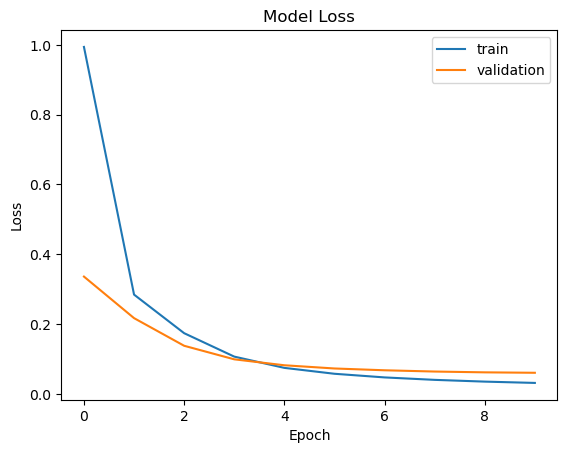

In [91]:
# visualise training history
plt.plot(bilstm_training.history['loss'])  # Use 'loss' instead of 'acc' for training loss
plt.plot(bilstm_training.history['val_loss'])  # Use 'val_loss' instead of 'val_acc' for validation loss
plt.title('Model Loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['train', 'validation'], loc="upper right")
plt.show()

In [92]:
# Predicting using the LSTM model on the test data
y_pred = bidirect_model.predict(X_test)

22/22 [==============================] - 1s 23ms/step


In [93]:
# Evaluate the RNN model on the test set
loss, accuracy = bidirect_model.evaluate(X_test, Y_test, verbose=0)

# Apply one-hot encoding to predictions
one_hot_encoded_data_3d = one_hot_encode_3d(y_pred)

# Flattening the arrays to 2D for multi-label classification
y_true_flat = Y_test.reshape(-1, Y_test.shape[-1])
y_pred_flat = one_hot_encoded_data_3d.reshape(-1, one_hot_encoded_data_3d.shape[-1])

# Calculate the F1 score
result_1 = f1_score(y_true_flat, y_pred_flat, average="weighted")

# Print the weighted F1-Score
print(f"Weighted F1-Score: {round(result_1 * 100, 2)} %")

# Print accuracy in a similar format
print(f"Accuracy: {round(accuracy * 100, 2)} %")

Weighted F1-Score: 97.66 %
Accuracy: 97.71 %


## Step 7 : Inference Using NetworkX

In [103]:
# Define a function to classify part-of-speech tags for words in a given sentence
def classify(sentence):
    seq = word_tokenizer.texts_to_sequences([sentence])
    pad_seq = pad_sequences(seq, maxlen=MAX_SEQ_LENGTH, padding=PADDING, truncating=TRUNCATING)
    pred = bidirect_model.predict(pad_seq).argmax(-1)
    output = [tag_tokenizer.index_word[tag] for tag in pred[0] if tag != 0]
    return output

# Sample sentence
sentence = "يريد الزوجان زيارة الولايات المتحدة العام القادم فى فصل الصيف"

# Apply the classify function to obtain part-of-speech tags for each word in the sentence
output = classify(sentence)

# Ensure all words are considered, even if the output list is shorter
pos_tagged_words = [(word, output[i] if i < len(output) else None) for i, word in enumerate(sentence.split())]

# Print the part-of-speech tags for each word in the sentence
print("Pos Tagged Words:", pos_tagged_words)

1/1 [==============================] - 1s 676ms/step
Pos Tagged Words: [('يريد', 'verb'), ('الزوجان', 'noun'), ('زيارة', 'noun'), ('الولايات', 'noun'), ('المتحدة', 'adj'), ('العام', 'adj'), ('القادم', 'adj'), ('فى', 'adp'), ('فصل', 'noun'), ('الصيف', 'noun')]


#### Using NetworkX for drawing a directed graph

In [120]:
def draw_directed_graph(pos_tagged_words):
    # Create a directed graph
    G = nx.DiGraph()

    # Add nodes and edges based on the POS tags
    for i in range(len(pos_tagged_words) - 1):
        current_word, current_pos = pos_tagged_words[i]
        next_word, next_pos = pos_tagged_words[i + 1]

        G.add_node(current_word, pos=current_pos)
        G.add_node(next_word, pos=next_pos)
        G.add_edge(current_word, next_word)

    # Map POS tags to colors dynamically
    pos_to_color = {pos: sns.color_palette("husl", n_colors=len(set(tag for _, tag in pos_tagged_words)))[i] for i, pos in enumerate(set(tag for _, tag in pos_tagged_words))}

    # Create a list of colors for each node
    node_colors = [pos_to_color[G.nodes[node]["pos"]] for node in G.nodes]

    # Draw the graph with larger nodes
    pos = nx.spring_layout(G)
    nx.draw(G, pos, with_labels=False, node_color=node_colors, node_size=1500, font_size=10, font_color="white")

    # Add text labels (POS tags) centered inside each node with Arabic text
    for node, (x, y) in pos.items():
        reshaped_text = arabic_reshaper.reshape(node)
        bidi_text = get_display(reshaped_text)
        plt.text(x, y, f"{bidi_text}\n{G.nodes[node]['pos']}", fontsize=12, color="black", ha="center", va="center", fontfamily='Arial')

    # Show the graph
    plt.show()

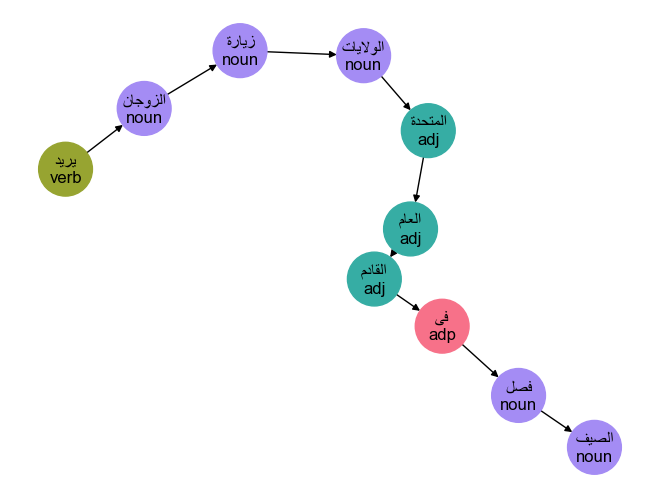

In [122]:
# Assuming 'pos_tagged_words' is your list of POS tagged words from the previous code.
draw_directed_graph(pos_tagged_words)

#### Another way to use NetworkX rather than drawing a directed graph

In [139]:
def create_graph(pos_tags):
    # Create an empty graph using NetworkX
    Graph = nx.Graph()

    # Add nodes to the graph based on unique words and POS tags
    for word, tag in pos_tags:
        if tag:  # Check if tag is not None
            Graph.add_node(word, pos_tag=tag)

    # Add edges to the graph connecting words with the same POS tag
    for word1, tag1 in pos_tags:
        for word2, tag2 in pos_tags:
            if tag1 and tag2 and tag1 == tag2 and word1 != word2:  # Check if tags are not None
                if not Graph.has_edge(word1, word2):
                    Graph.add_edge(word1, word2)

    return Graph

def draw_graph(graph, font_size=20):
    plt.figure(figsize=(20, 10))
    pos = nx.spring_layout(graph, k=0.5, seed=42)
    labels = nx.get_node_attributes(graph, 'pos_tag')
    node_labels = {node: f"{node} ({labels.get(node, '')})" for node in graph.nodes()}

    # Reshape Arabic text using arabic_reshaper and get_display
    reshaped_labels = {node: get_display(arabic_reshaper.reshape(label)) for node, label in node_labels.items()}

    nx.draw(
        graph,
        pos,
        with_labels=True,
        labels=reshaped_labels,
        font_size=font_size,
        node_size=1000,  # Adjust the node size as needed
        font_color='black',
        node_color='lightblue',
        edge_color='gray',
        width=1,
        alpha=1
    )

    plt.title("Arabic Part Of Speech Tagging with NetworkX", fontsize=font_size+5, fontweight='bold')
    plt.axis('off')
    plt.show()

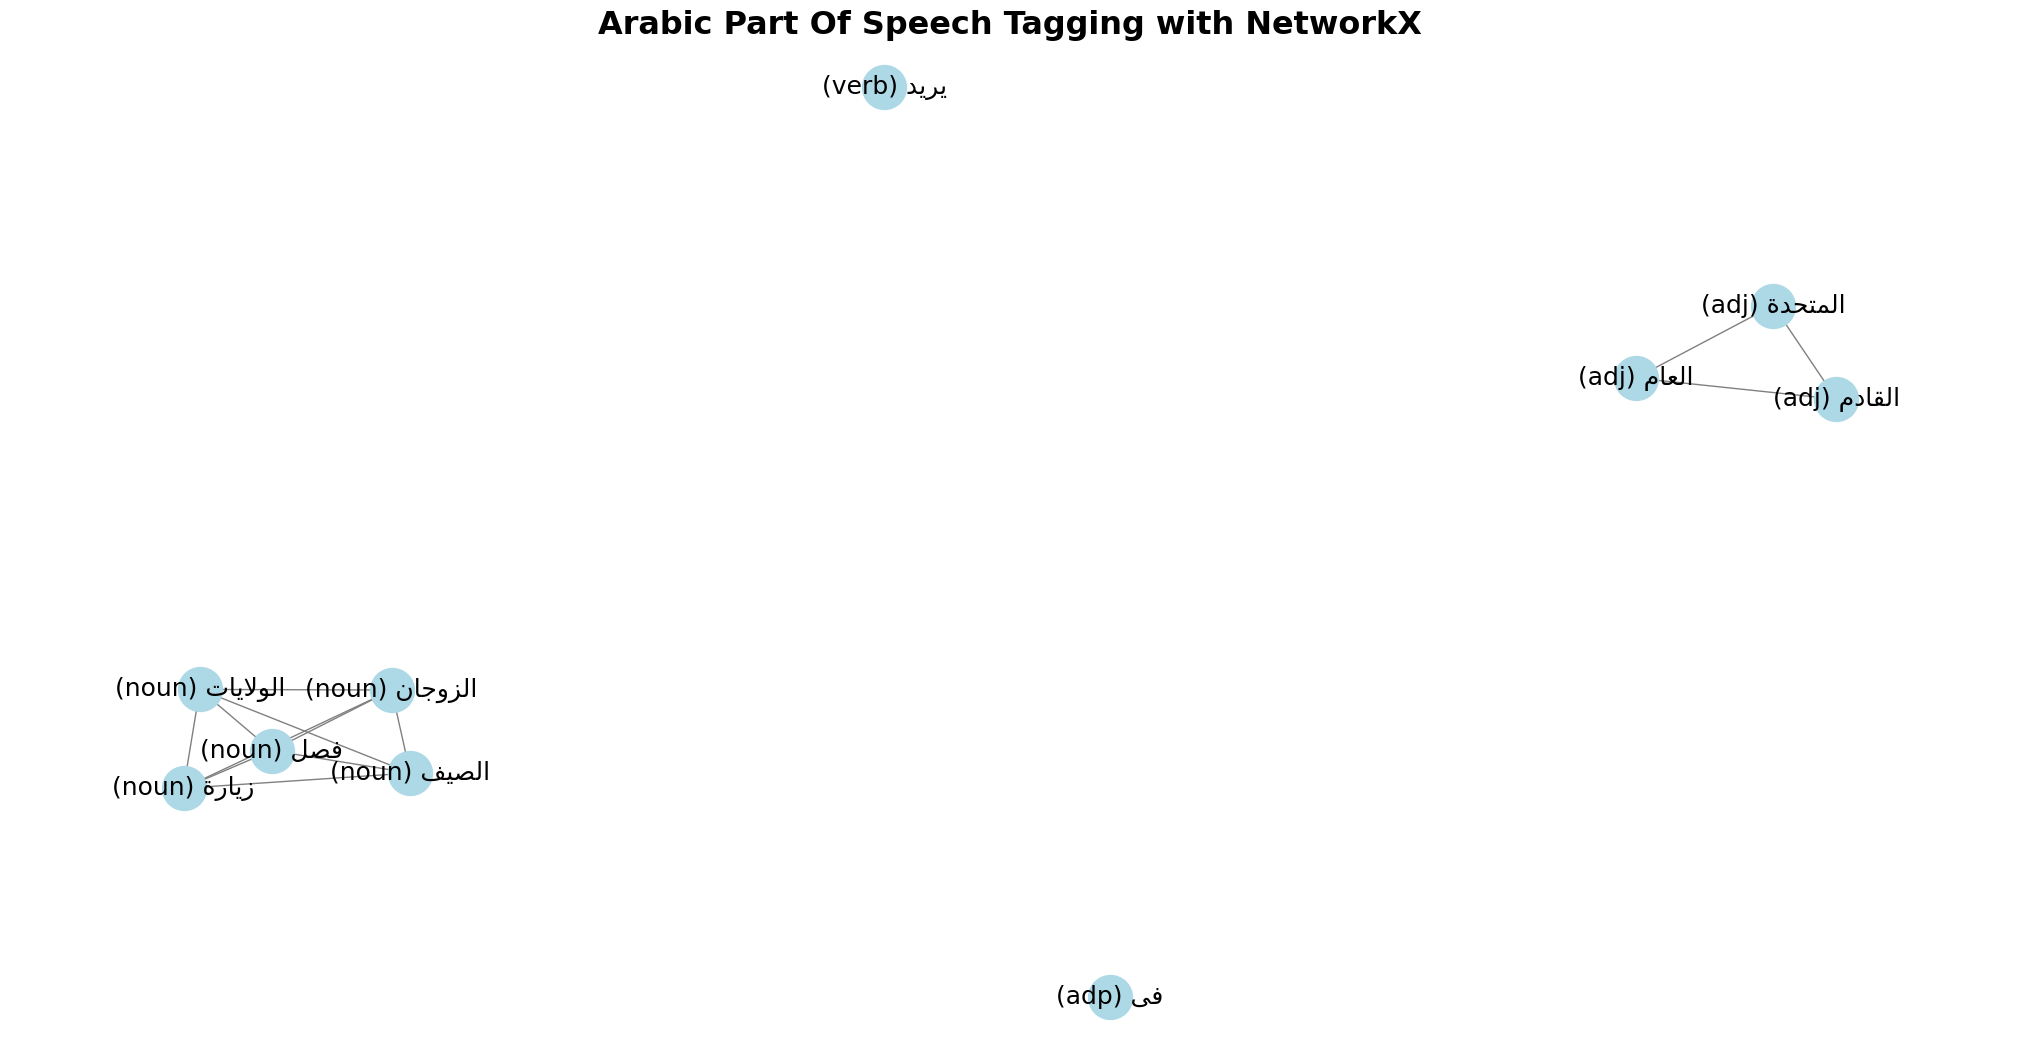

In [140]:
# 'pos_tagged_words' is my list of POS tagged words
graph = create_graph(pos_tagged_words)
draw_graph(graph, font_size=18)  # You can adjust the font size as needed